Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/15/cnn1d_sentiment_torch.ipynb

# 1d CNNs for sentiment classification

We use 1d CNNs for IMDB movie review classification.
Based on sec 15.3 of http://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html




     |████████████████████████████████| 184 kB 4.3 MB/s 
     |████████████████████████████████| 136 kB 50.7 MB/s 
     |████████████████████████████████| 72 kB 786 kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

import jax
import jax.numpy as jnp

try:
    from flax import linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn
from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

import collections
import re
import random
import os
import requests
import zipfile
import tarfile
import hashlib
import time
import functools
from typing import Sequence

rng = jax.random.PRNGKey(0)
!mkdir figures # for saving plots

# Data

We use IMDB dataset. Details in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/rnn_sentiment_torch.ipynb).

In [3]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [4]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ("pos", "neg"):
        folder_name = os.path.join(data_dir, "train" if is_train else "test", label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), "rb") as f:
                review = f.read().decode("utf-8").replace("\n", "")
                data.append(review)
                labels.append(1 if label == "pos" else 0)
    return data, labels

We tokenize using words, and drop words which occur less than 5 times in training set when creating the vocab.

In [5]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    display.set_matplotlib_formats("svg")
    plt.rcParams["figure.figsize"] = figsize

We pad all sequences to length 500, for efficient minibatching.

In [6]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

Putting it altogether.

In [7]:
def load_data_imdb(num_steps=500):
    data_dir = download_extract("aclImdb", "aclImdb")
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token="word")
    test_tokens = tokenize(test_data[0], token="word")
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = jnp.asarray([truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens])
    test_features = jnp.asarray([truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in test_tokens])
    train_labels = jnp.asarray(train_data[1])
    test_labels = jnp.asarray(test_data[1])
    train_ds = {"text": train_features, "label": train_labels}
    test_ds = {"text": test_features, "label": test_labels}

    return train_ds, test_ds, vocab

In [8]:
DATA_HUB = dict()
DATA_HUB["aclImdb"] = (
    "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    "01ada507287d82875905620988597833ad4e0903",
)

data_dir = download_extract("aclImdb", "aclImdb")

In [9]:
train_ds, test_ds, vocab = load_data_imdb()

In [10]:
assert train_ds["text"].shape == (25000, 500)
assert train_ds["label"].shape == (25000,)
assert test_ds["text"].shape == (25000, 500)
assert test_ds["label"].shape == (25000,)

# Model

We load pretrained Glove vectors. We use these to initialize the embedding layers, one of which is frozen.


In [11]:
class TokenEmbedding:
    """Token Embedding."""

    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ["<unk>"], []
        data_dir = download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, "vec.txt"), "r") as f:
            for line in f:
                elems = line.rstrip().split(" ")
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, np.array(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[np.array(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [12]:
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.100d.zip"
DATA_HUB["glove.6b.100d"] = (DATA_URL, "cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a")
glove_embedding = TokenEmbedding("glove.6b.100d")
embeds = jnp.array(glove_embedding[vocab.idx_to_token])
assert embeds.shape == (49346, 100)

We use 2 embedding layers, one with frozen weights, and one with learnable weights. We feed their concatenation to the 1d CNN. We then do average pooling over time before passing into the final MLP to map to the 2 output logits.

In [13]:
class TextCNN(nn.Module):
    vocab_size: int
    embed_size: int
    kernel_sizes: Sequence[int]
    num_channels: Sequence[int]
    embeds: jnp.array

    def setup(self):
        self.embedding = nn.Embed(self.vocab_size, self.embed_size, embedding_init=lambda *_: self.embeds)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embed(self.vocab_size, self.embed_size, embedding_init=lambda *_: self.embeds)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        self.convs = [
            nn.Conv(features=c, kernel_size=(k,), padding="VALID") for c, k in zip(self.num_channels, self.kernel_sizes)
        ]

    def __call__(self, x, *, train):
        batch_size, num_words = x.shape

        # Concatenate the output of two embedding layers with shape of
        # (batch size, no. of words, word vector dimension) by word vector
        embeddings = jnp.concatenate([self.embedding(x), self.constant_embedding(x)], axis=2)
        assert embeddings.shape == (batch_size, num_words, 2 * self.embed_size)

        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor with the shape of (batch size, 1, channel size)
        # can be obtained
        for conv, c, k in zip(self.convs, self.num_channels, self.kernel_sizes):
            assert conv(embeddings).shape == (batch_size, num_words + 1 - k, c)
            assert nn.max_pool(conv(embeddings), window_shape=(num_words + 1 - k,)).shape == (batch_size, 1, c)

        # Use the flatten function to remove the penultimate dimension and
        # then concatenate on the channel dimension
        encoding = jnp.concatenate(
            [
                jnp.squeeze(nn.relu(nn.max_pool(conv(embeddings), window_shape=(num_words + 1 - k,))), axis=1)
                for conv, k in zip(self.convs, self.kernel_sizes)
            ],
            axis=1,
        )
        assert encoding.shape == (batch_size, sum(self.num_channels))

        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding, deterministic=not train))
        assert outputs.shape == (batch_size, 2)

        return outputs

In [14]:
embed_size, kernel_sizes, num_channels = 100, [3, 4, 5], [100, 100, 100]
TextCNN = functools.partial(TextCNN, len(vocab), embed_size, kernel_sizes, num_channels, embeds)

# Training

In [15]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [17]:
def compute_metrics(*, logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=2)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics


def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    cnn = TextCNN()
    params = cnn.init(rng, jnp.ones([1, 500], dtype=int), train=False)["params"]
    tx = optax.adam(
        learning_rate,
    )
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

In [18]:
@jax.jit
def train_step(state, batch, dropout_rng):
    """Train for a single step."""

    def loss_fn(params):
        logits = TextCNN().apply({"params": params}, batch["text"], train=True, rngs={"dropout": dropout_rng})
        one_hot = jax.nn.one_hot(batch["label"], num_classes=2)
        loss = jnp.sum(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    grads = grads.copy({"constant_embedding": {"embedding": 0}})  # don't update this layer
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch["label"])
    return state, metrics


@jax.jit
def eval_step(params, batch):
    logits = TextCNN().apply({"params": params}, batch["text"], train=False)
    return compute_metrics(logits=logits, labels=batch["label"])


def train_epoch(state, train_ds, batch_size, epoch, rng, dropout_rng, animator):
    """Train for a single epoch."""
    train_ds_size = len(train_ds["text"])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch, dropout_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    animator.add(epoch, (epoch_metrics_np["loss"], epoch_metrics_np["accuracy"], None))
    print(
        "train epoch: %d, loss: %.4f, accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
    )

    return state


def eval_model(params, test_ds, batch_size):
    test_ds_size = len(test_ds["text"])
    steps_per_epoch = test_ds_size // batch_size

    perms = jax.random.permutation(rng, test_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in test_ds.items()}
        metrics = eval_step(params, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    return epoch_metrics_np["loss"], epoch_metrics_np["accuracy"]

# Learning curve

In [19]:
rng, init_rng = jax.random.split(rng)
learning_rate = 0.001
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

test epoch: 5, test_loss: 0.33, accuracy: 87.98


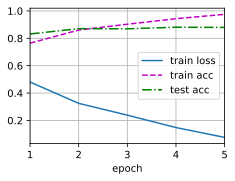

In [20]:
num_epochs = 5
batch_size = 64

animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # dropout needs PRNG for "dropout"
    rng, dropout_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng, dropout_rng, animator)
    # Evaluate on the test set after each training epoch
    test_loss, test_accuracy = eval_model(state.params, test_ds, batch_size)
    animator.add(epoch, (None, None, test_accuracy))
    print("test epoch: %d, test_loss: %.2f, accuracy: %.2f" % (epoch, test_loss, test_accuracy * 100))

# Testing

In [21]:
def predict_sentiment(params, vocab, sentence):
    sentence = jnp.asarray(vocab[sentence.split()])
    logits = TextCNN().apply({"params": params}, sentence.reshape(1, -1), train=False)
    label = jnp.argmax(logits, axis=1)
    return "positive" if label == 1 else "negative"

In [22]:
predict_sentiment(state.params, vocab, "this movie is so great")

'positive'

In [23]:
predict_sentiment(state.params, vocab, "this movie is so bad")

'negative'